In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

import warnings
warnings.filterwarnings("ignore")
sns.set(style="whitegrid")


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Upload your CSV file or use a sample dataset
df = pd.read_csv('unprocessed_customer_data_tamilnadu.csv')  # Replace with actual path or upload

df.head()


,CustomerID,ProductID,Price,CustomerName,DateOfPurchase,Location,BankBalanceAfterPurchase,Age,Gender,Occupation
0,CUST1000,PROD754,960,Jayan Badal,2024-02-17,"Bhind, Tamil Nadu",44113.23,45,Female,Engineer
1,CUST1001,PROD214,3872,Raghav Agate,2024-09-21,"Shahjahanpur, Tamil Nadu",73645.74,67,Male,Doctor
2,CUST1002,PROD125,3192,Shaan Shere,2024-07-19,"Indore, Tamil Nadu",96581.90,38,Female,Teacher
3,CUST1003,PROD859,566,Shamik Trivedi,2024-07-13,"Davanagere, Tamil Nadu",27738.16,66,Male,Doctor
4,CUST1004,PROD381,4526,Aarush Deep,2023-11-15,"Siwan, Tamil Nadu",81011.72,24,Female,Business


In [ ]:
# Check nulls
print(df.isnull().sum())
df.isnull().sum()

# Fill numeric nulls with mean
numeric_cols = df.select_dtypes(include='number').columns
df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].mean())

# Drop non-numeric or irrelevant columns if needed (like IDs, names, etc.)
df.drop(columns=['CustomerID', 'Name'], errors='ignore', inplace=True)

# Encode categoricals
df = pd.get_dummies(df, drop_first=True)


CustomerID                  0
ProductID                   0
Price                       0
CustomerName                0
DateOfPurchase              0
Location                    0
BankBalanceAfterPurchase    0
Age                         0
Gender                      0
Occupation                  0
dtype: int64


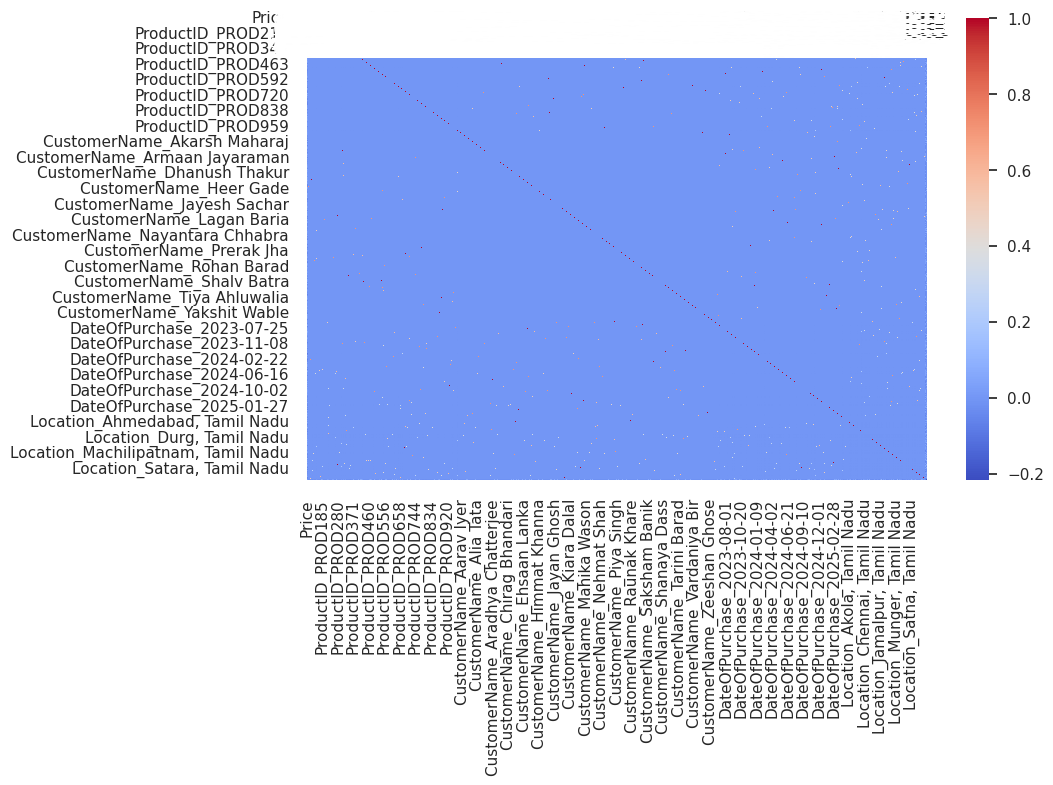

In [ ]:
# Summary stats
df.describe()

# Visualize correlations
plt.figure(figsize=(10, 6))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title("Feature Correlation Heatmap")
plt.show()

# Distribution plots
df.hist(bins=20, figsize=(12, 8))
plt.suptitle("Feature Distributions")
plt.show()


In [ ]:
# Create any derived metrics
# Example: Average purchase value = TotalSpent / TotalVisits
if 'TotalSpent' in df.columns and 'TotalVisits' in df.columns:
    df['AvgPurchaseValue'] = df['TotalSpent'] / (df['TotalVisits'] + 1)  # +1 to avoid div by zero


In [ ]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df)


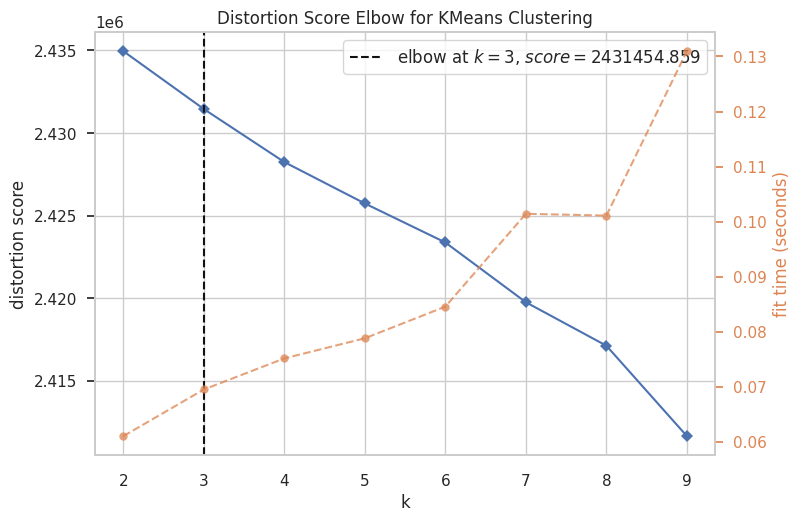

Optimal number of clusters: 3


In [ ]:
model = KMeans()
visualizer = KElbowVisualizer(model, k=(2, 10))
visualizer.fit(scaled_data)
visualizer.show()

# Save optimal K
optimal_k = visualizer.elbow_value_
print(f"Optimal number of clusters: {optimal_k}")


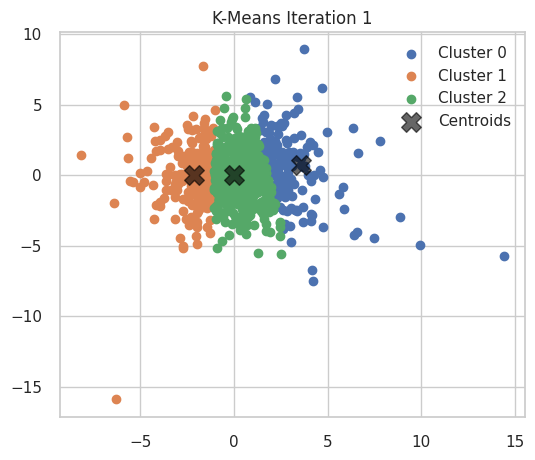

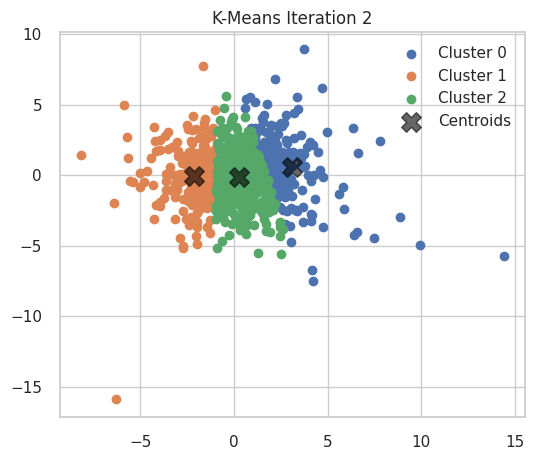

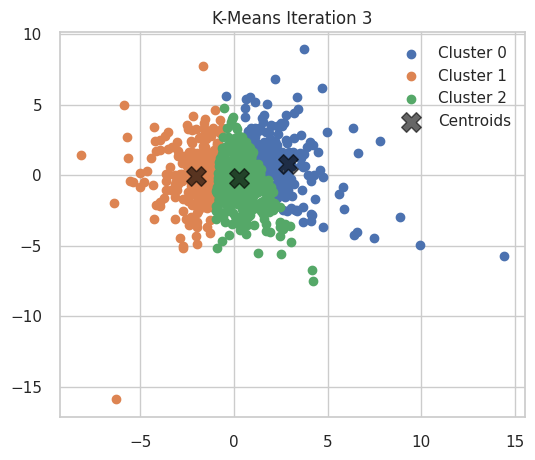

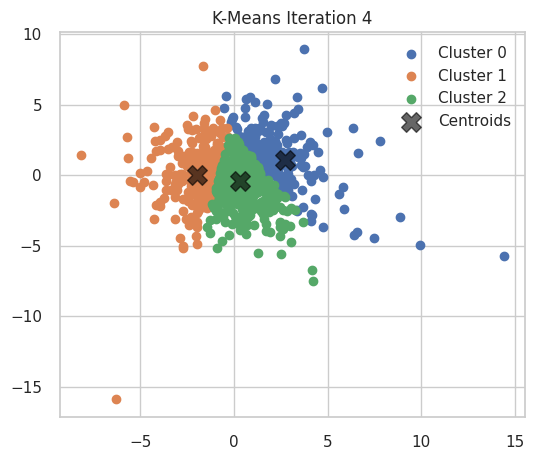

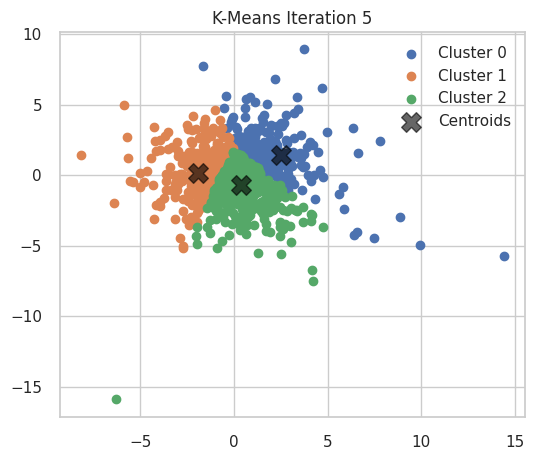

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import pairwise_distances_argmin
from sklearn.cluster import KMeans

# Step 1: Apply PCA for 2D visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(scaled_data)

# Step 2: Set default number of clusters if not defined
try:
    optimal_k
except NameError:
    optimal_k = 3

# Step 3: Function to visualize K-Means iterations
def plot_kmeans_iterations(X, k, max_iter=5):
    np.random.seed(42)
    centers = X[np.random.choice(X.shape[0], k, replace=False)]

    for i in range(max_iter):
        labels = pairwise_distances_argmin(X, centers)

        plt.figure(figsize=(6, 5))
        for j in range(k):
            plt.scatter(X[labels == j, 0], X[labels == j, 1], label=f'Cluster {j}')
        plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.6, marker='X', label='Centroids')
        plt.title(f'K-Means Iteration {i + 1}')
        plt.legend()
        plt.grid(True)
        plt.show()

        new_centers = np.array([X[labels == j].mean(axis=0) for j in range(k)])
        if np.allclose(centers, new_centers):
            break
        centers = new_centers

# Step 4: Run the visualization
plot_kmeans_iterations(X_pca, optimal_k)


In [ ]:
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
df['Cluster'] = kmeans.fit_predict(scaled_data)


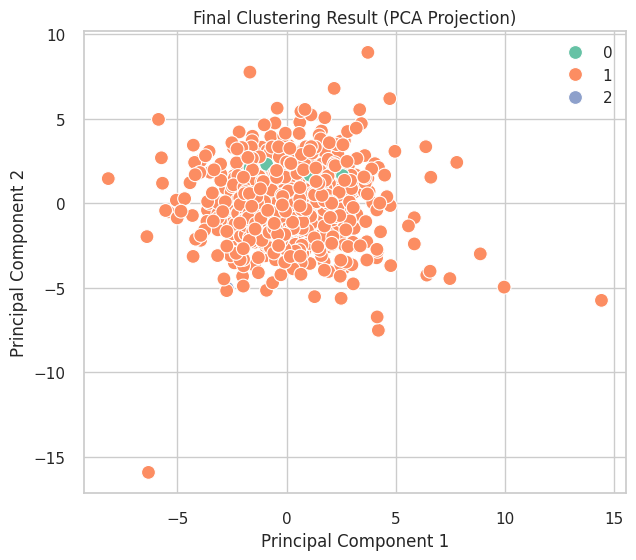

In [ ]:
plt.figure(figsize=(7, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=df['Cluster'], palette='Set2', s=100)
plt.title('Final Clustering Result (PCA Projection)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# Group by cluster and compute mean values
cluster_summary = df.groupby('Cluster').mean()
cluster_summary


,Price,BankBalanceAfterPurchase,Age,ProductID_PROD101,ProductID_PROD102,ProductID_PROD103,ProductID_PROD105,ProductID_PROD106,ProductID_PROD107,ProductID_PROD108,...,"Location_Visakhapatnam, Tamil Nadu","Location_Warangal, Tamil Nadu","Location_Yamunanagar, Tamil Nadu",Gender_Male,Gender_Other,Occupation_Doctor,Occupation_Engineer,Occupation_Retired,Occupation_Student,Occupation_Teacher
Cluster,,,,,,,,,,,,,,,,,,,,,
0,2524.666667,34802.428889,43.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.222222,0.000000,0.111111,0.111111,0.111111,0.222222,0.222222
1,2615.146465,51547.375374,43.89798,0.00101,0.00101,0.00202,0.00101,0.00202,0.00101,0.00101,...,0.00404,0.00202,0.00404,0.479798,0.041414,0.175758,0.156566,0.156566,0.182828,0.167677
2,3681.000000,4982.940000,40.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
